---

# Sentiment Analysis from Tweets
---
 Given a tweet or short text, the goal is to train a model to predict the `sentiment` for a given `text` by identifying the overall emotional tone of the tweet (positive, negative, neutral).

**Dataset**

"Tweet Sentiment Extraction" from [Kaggle](https://www.kaggle.com/competitions/tweet-sentiment-extraction/data), focuses on the task of **extracting sentiment-bearing phrases from tweets**. It's designed for training machine learning models to understand the nuanced sentiments expressed in tweets and identify the specific text within the tweet that conveys that sentiment. Here's a breakdown of the dataset:

**Data Structure:**

* **`train.csv`:** Contains the training data with 27480 rows.
* **`test.csv`:** Contains the testing data with 3534 rows.

**Columns:**

* **`text`:** The full text of the tweet. I will use this column in the following work.
* **`sentiment`:** The overall sentiment of the tweet, classified as either "positive", "negative", or "neutral".
* **`selected_text`:** The portion of the tweet that expresses the sentiment (this is the target variable). 

---
## SETUP
---

**Import Dependencies**

In [1]:
import os
import re
import sys
import time
import gc
import random
from tqdm import tqdm
import numpy as np


**Color Palette Specifications**

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

palette_color  = sns.color_palette("pastel",10)
sns.set_theme(style="whitegrid", palette=palette_color)

palette_color

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

**Pandas Specifications**

In [2]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.precision = 0
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Change Current Working Directory**

In [4]:
# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Change the working directory to a specific path
os.chdir('/mnt/d/ai/WideBotAI')

# Verify the change
current_dir = os.getcwd()
print(f"New working directory: {current_dir}")

if not 'WideBotAI' in sys.path:
    sys.path += ['WideBotAI']

Current working directory: /mnt/d/ai/WideBotAI/Sentiment-Analysis
New working directory: /mnt/d/ai/WideBotAI


**Setup GPU**

In [5]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


**Set random seed**

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

---
## Load dataset and EDA
---

**Import Datasets**

In [12]:
import opendatasets as od

train_data_dir='./data/tweet-sentiment-extraction/train.csv'
val_data_dir='./data/tweet-sentiment-extraction/test.csv'

if not os.path.exists(train_data_dir):
    od.download("https://www.kaggle.com/competitions/tweet-sentiment-extraction")

In [13]:

train_data_dir='./data/tweet-sentiment-extraction/train.csv'
val_data_dir='./data/tweet-sentiment-extraction/test.csv'

train_df = pd.read_csv(train_data_dir)
val_df = pd.read_csv(val_data_dir)

train_df.shape
val_df.shape

(27481, 4)

(3534, 3)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


**Check Missing Text**

In [15]:
train_df[['text', 'sentiment']].isna().sum()
val_df[['text', 'sentiment']].isna().sum()

text         1
sentiment    0
dtype: int64

text         0
sentiment    0
dtype: int64

In [16]:
train_df[train_df['text'].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [17]:
train_df = train_df.dropna()

**Check Duplication**

In [18]:
train_df['text'].duplicated().sum()
val_df['text'].duplicated().sum()

0

0

**Encode Label column**

In [19]:
labels = {'negative':0, 'neutral': 1, 'positive':2}
train_df['label'] = train_df['sentiment'].map(labels)
val_df['label'] = val_df['sentiment'].map(labels)

**How many tweets (sentences) was used to train and validation?**

Answering this quesion should be after drop the duplicated text, So:
 

In [20]:
print(f"There are {len(train_df)} sentences in the training set")
print(f"There are {len(val_df)} sentences in the testing set")

There are 27480 sentences in the training set
There are 3534 sentences in the testing set


In [21]:
train_df['sentiment'].unique()
val_df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

array(['neutral', 'positive', 'negative'], dtype=object)

**What are the distributions of labels**
    

In [22]:
def Check_balance(df):
    """
    Visualizes the class balance in a DataFrame with sentiment labels.

    This function creates two plots: a pie chart and a bar chart, 
    showing the distribution of sentiment labels in the given DataFrame.

    Args:
        df (pandas.DataFrame): A DataFrame containing a 'sentiment' column.

    Returns:
        pandas.DataFrame: A DataFrame containing the counts and proportions of each sentiment label.
    """
    
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    
    labels_counts = df.groupby(['sentiment']).size().sort_values(ascending = False)
    labels_counts = labels_counts.to_frame(name='count')
    labels_counts['proportion'] = labels_counts.apply(lambda x: (x['count']/labels_counts['count'].sum())*100, axis=1)

    axs[0].pie(labels_counts['count'], labels=labels_counts.index,
               colors=palette_color, autopct='%1.2f%%', pctdistance=1.2,
               labeldistance=1.5, textprops={'fontsize': 9})

    sns.barplot(x = labels_counts.index, y = labels_counts['count'], ax=axs[1],palette=palette_color)

    axs[1].set_xlabel('', fontsize=12, rotation= 60)
    axs[1].set_ylabel('', fontsize=12)

    plt.tight_layout(h_pad =0.5, pad=3)
    plt.show()
    
    return labels_counts

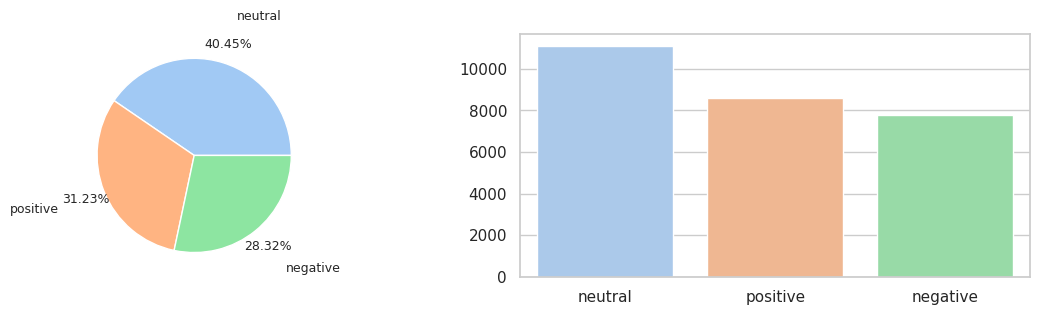

In [23]:
train_res = Check_balance(train_df )

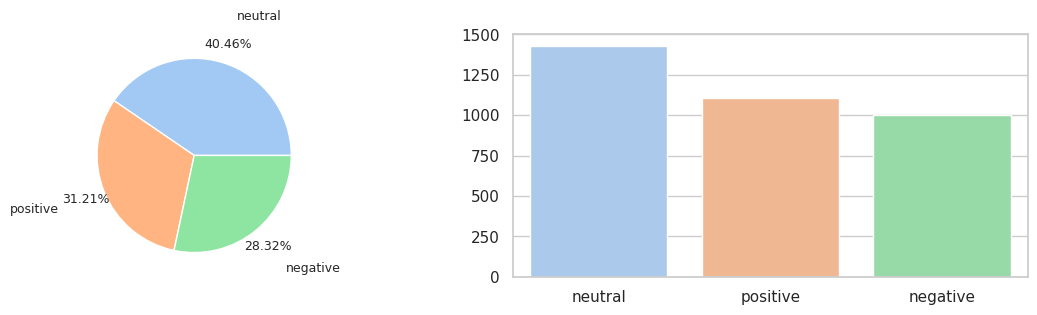

In [24]:
val_res = Check_balance(val_df )

In [25]:
train_res
val_res

,count,proportion
sentiment,,
neutral,11117,40.4549
positive,8582,31.2300
negative,7781,28.3151


,count,proportion
sentiment,,
neutral,1430,40.4641
positive,1103,31.2111
negative,1001,28.3248


<a ><font size="3"><b>OBSERVATION:</b></font></a>

* Both training and validation sets are relatively balanced.
* All three sentiments (neutral, positive, negative) are present in roughly equal proportions.
* There is a **slight bias** towards neutral sentiment in both datasets.

#### Analyze the words per tweet


In [26]:
def count_words(text):
    return len(text.split())

In [27]:
train_df['num_words'] = train_df['text'].apply(count_words)
val_df['num_words'] = val_df['text'].apply(count_words)

# Calculate mean words count per tweet by class
print('================ Training Dataset ================')
print(train_df.groupby('sentiment').num_words.mean())   
print('=============== Validation Dataset ===============')
print(val_df.groupby('sentiment').num_words.mean()) 


print('\n===== The mean words per tweet in each dataset ====')
print(f"Training set: Mean words per tweet = {train_df['num_words'].mean():.2f}")
print(f"Validation set: Mean words per tweet = {val_df['num_words'].mean():.2f}")

================ Training Dataset ================
sentiment
negative   13.4732
neutral    12.3439
positive   13.1099
Name: num_words, dtype: float64
=============== Validation Dataset ===============
sentiment
negative   13.2507
neutral    12.4420
positive   12.7371
Name: num_words, dtype: float64

===== The mean words per tweet in each dataset ====
Training set: Mean words per tweet = 12.90
Validation set: Mean words per tweet = 12.76


<a ><font size="3"><b>OBSERVATION:</b></font></a>
- These results suggest that the tweets in the dataset are relatively short, with an average length of around 12 words per tweet. 
- No variation in mean words per tweet between the classes.
- This information is useful in selecting appropriate text processing methods, such as setting the maximum sequence length

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stop_words = list(STOPWORDS)

def CloudWords(df):
    """
    Generates word clouds for each sentiment in a DataFrame.

    This function creates a single row of subplots, each displaying a word cloud
    representing the most frequent words in tweets associated with a specific sentiment.

    Args:
        df (pandas.DataFrame): A DataFrame containing 'sentiment' and 'text' columns.

    Returns:
        None
    """
    n_col = len(df["sentiment"].unique())  # Number of unique sentiments
    fig, axs = plt.subplots(1, n_col, figsize=(20, 7))  # One row of subplots
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, label in enumerate(df["sentiment"].unique()):
        tweets = df[df["sentiment"] == label]['text']
        text = ' '.join(tweets)

        wordcloud = WordCloud(width=800, height=800, background_color='black',
                              stopwords=stop_words, max_font_size=150).generate(text)

        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].set_title(f"{label} Tweets".title(), fontsize=14)
        axs[i].axis("off")

    plt.show()

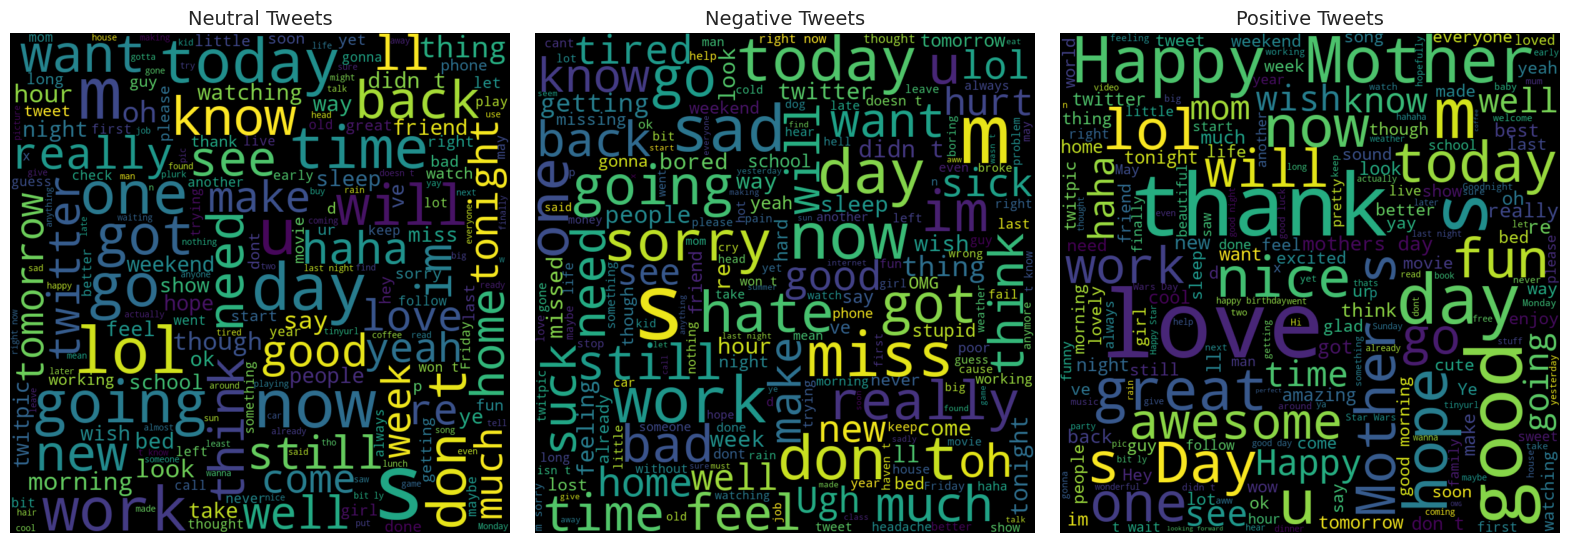

In [29]:
CloudWords(train_df)

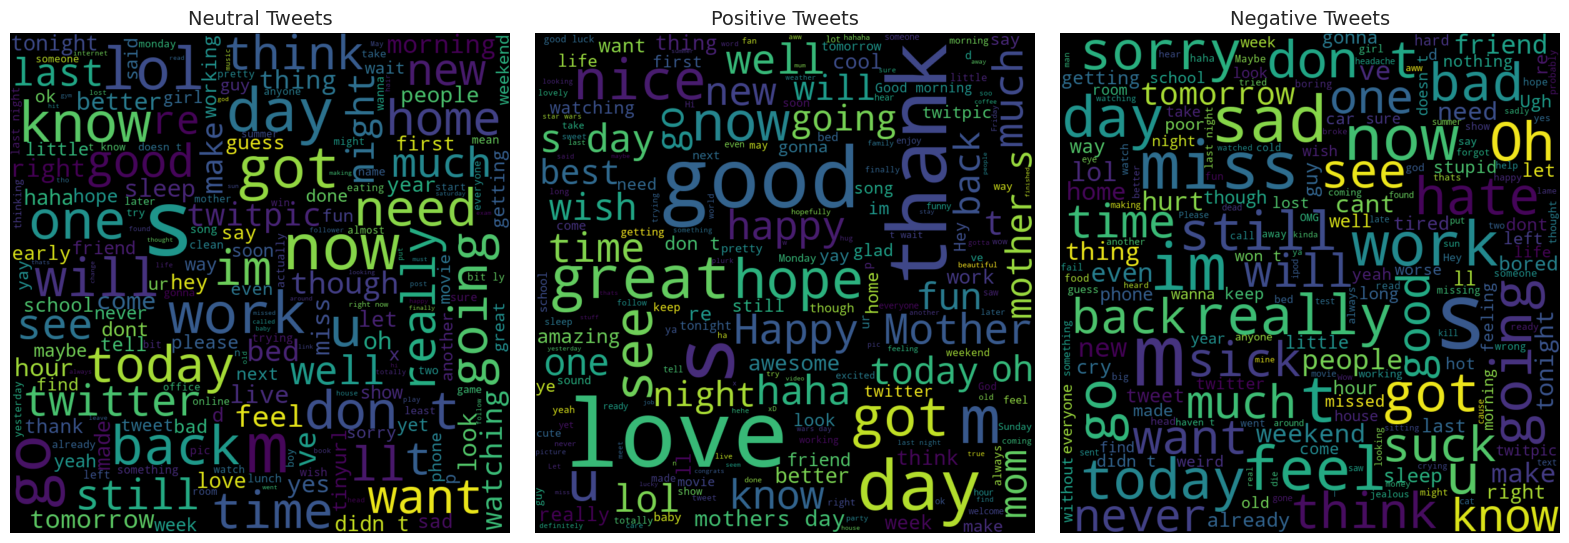

In [30]:
CloudWords(val_df)

**N-Gram Analysis**

In [31]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [32]:
from nltk.util import ngrams

def draw_n_gram(sentences,i):

    """
    Draws a bar plot of the top 15 n-grams from a list of texts.

    Args:
        texts (list): A list of strings containing the texts to analyze.
        i (int): The n-gram size (e.g., 1 for unigrams, 2 for bigrams).

    Returns:
        matplotlib.axes.Axes: The bar plot object.
    """

    all_words = []
    for text in sentences:
        all_words.extend(text.split())  # Add words from each text to the list

    n_gram = (pd.Series(nltk.ngrams(all_words, i)).value_counts())[:15]
    n_gram_df = pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize=(16, 9))
    return sns.barplot(x='count', y='word', data=n_gram_df)


     word  count
0   (to,)   9809
1    (I,)   8802
2  (the,)   8388
3    (a,)   6501
4   (my,)   4932


<AxesSubplot: xlabel='count', ylabel='word'>

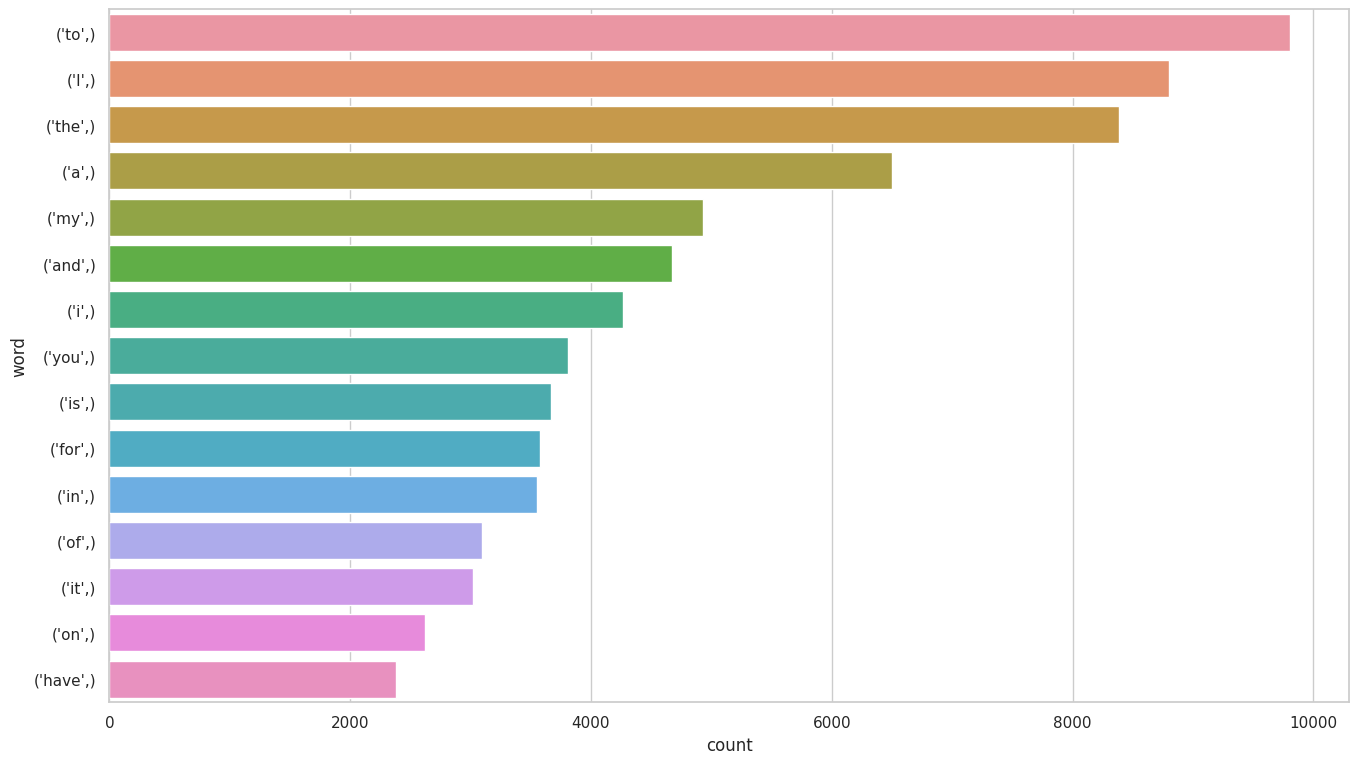

In [33]:
train_texts = train_df['text'].tolist()
draw_n_gram(train_texts,1)

          word  count
0    (in, the)    779
1  (going, to)    624
2     (to, be)    522
3   (for, the)    514
4    (I, have)    498


<AxesSubplot: xlabel='count', ylabel='word'>

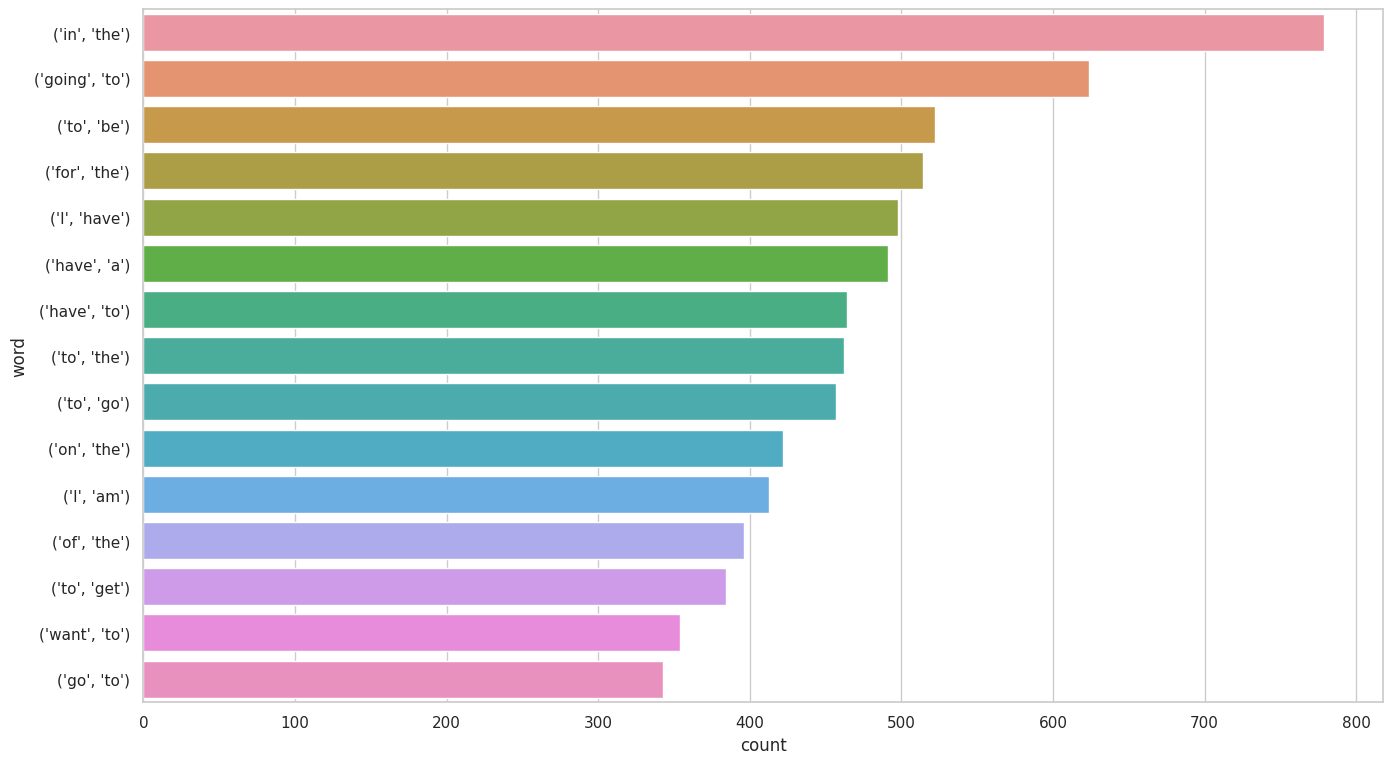

In [34]:
draw_n_gram(train_texts,2)

                     word  count
0            (to, go, to)    177
1           (I, have, to)    117
2           (I, want, to)    102
3         (going, to, be)    102
4  (Happy, Mother`s, Day)     94


<AxesSubplot: xlabel='count', ylabel='word'>

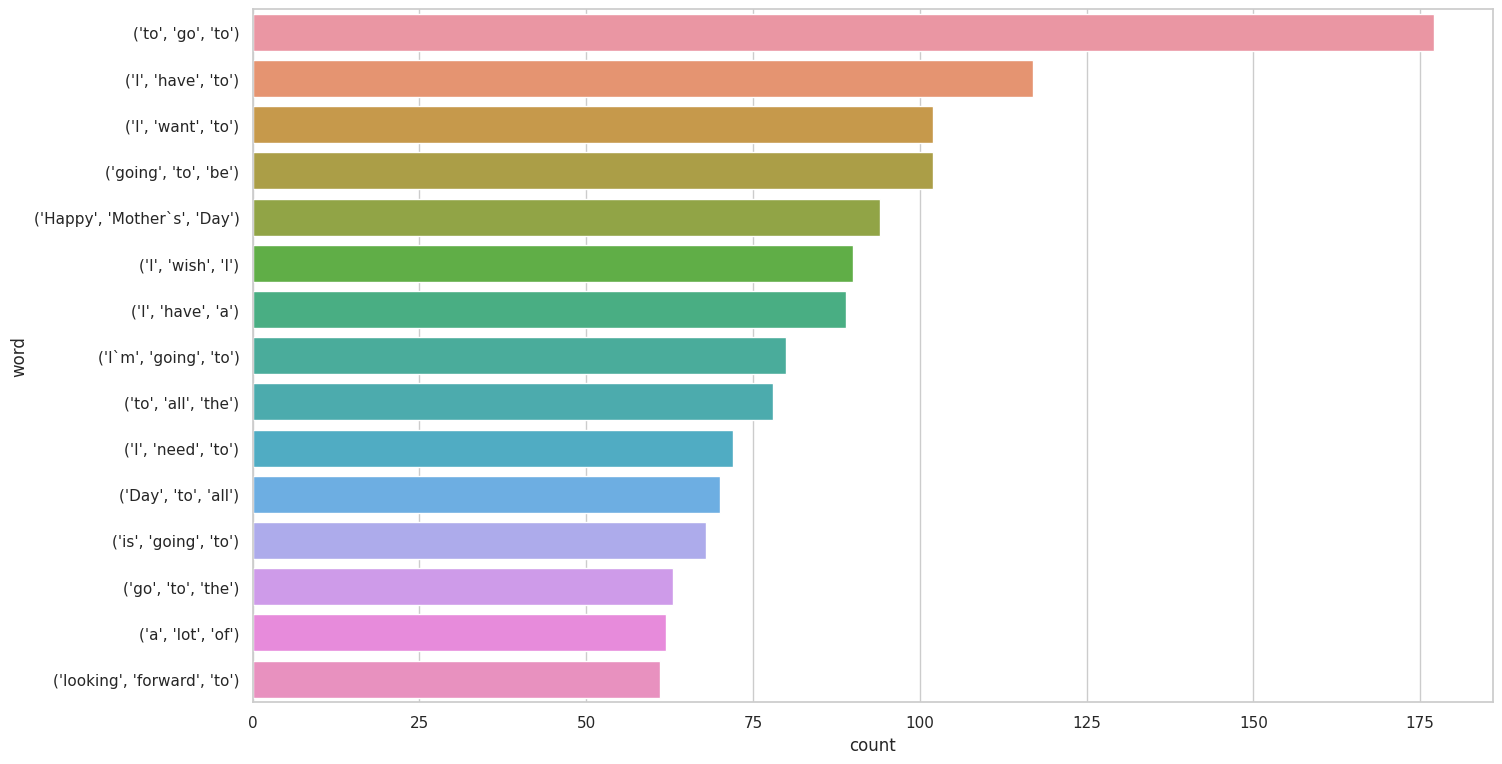

In [35]:
draw_n_gram(train_texts,3)

**Check for special characters**

In [36]:
# What is the percentage of rows where the text column contains a special character
train_df[train_df['text'].str.contains(r"[^a-zA-Z0-9\s]")]['text'].count() / len(train_df)

0.858042212518195

**Check for punctuation marks**

In [37]:
# What is the percentage of rows where the text column contains any punctuation mark
train_df[train_df["text"].str.contains(r"[.,?!;:\-\(\)\[\]\{\}/\"'…]")]['text'].count() / len(train_df)

0.8033842794759826

**Check for single characters**

In [38]:
single_char_matches = train_df[train_df["text"].str.contains(r"\b[t|s|m|d|y|ve|ll|re]\b", regex = True)]
single_char_matches.shape

(7572, 6)

**Check the negative format**

In [39]:
def Check_format(df, check_words):
    
    for w in check_words:
        check = df[df['text'].str.contains(w, case=False)]['text']
        if not check.empty:
            print(f"Word `{w}` exist in the dataset, here is an sample: \n")
            print(check.values[0])
            print("-"*80)
        else:
            print(f"Word `{w}` not in the dataset\n")
            check_words.remove(w)
    return check_words

In [40]:
InteractiveShell.ast_node_interactivity = 'last_expr'
words1 = [" cant ", " couldnt ", " shouldnt ", " isnt ", " aint ", " arent ",
         " doesnt ", " didnt ", " didnt ", " hasnt ", " hadnt ", " maynt ", " mightnt ",
         " mustnt ", " neednt ", " oughtnt ", " shant ", " wont ", " wasnt "," werent "]
    
words1 = Check_format(train_df, words1)
print("#"*80)
print(words1)

Word ` cant ` exist in the dataset, here is an sample: 

 Haha I know, I cant handle the fame!  and thank you!
--------------------------------------------------------------------------------
Word ` couldnt ` exist in the dataset, here is an sample: 

__buckley Good for you mate, sadly I couldnt get pissed tonight **** driving bad times
--------------------------------------------------------------------------------
Word ` shouldnt ` exist in the dataset, here is an sample: 

i know i was wrong. maybe i shouldnt did all of those **** things like that
--------------------------------------------------------------------------------
Word ` isnt ` exist in the dataset, here is an sample: 

so glad it is friday  two classes, then lazy afternoon. too bad it isnt nice and warm out today
--------------------------------------------------------------------------------
Word ` aint ` exist in the dataset, here is an sample: 

@ Barbs trying to figure out y the dsl aint connecting. I need my googl

**Check auxiliary verbs and pronoun contractions**

In [41]:
words2 = [' id ', ' ill ', ' im ', ' ive ', ' hes ', ' hows ', ' shed ', 
         ' shell ', ' shes ', ' itd ', ' itll ', ' its ', ' wed ', ' well ', 
         ' weve ', " youd ", ' youll ', ' youre ', ' youve ', ' theyd ', 
         ' theyll ', ' theyre ', ' theyve ']

words2 = Check_format(train_df, words2)
print("#"*80)
print(words2)

Word ` id ` exist in the dataset, here is an sample: 

 YoYo door nazis refused me entry on account of no ID  gutted! Heard it was a good night tho.. Next time I`ll come prepared!
--------------------------------------------------------------------------------
Word ` ill ` exist in the dataset, here is an sample: 

had a great time out in the beer garden wit the boyos !! I think the sun got to me a bit though, feel a bit ill !!
--------------------------------------------------------------------------------
Word ` im ` exist in the dataset, here is an sample: 

the free fillin` app on my ipod is fun, im addicted
--------------------------------------------------------------------------------
Word ` ive ` exist in the dataset, here is an sample: 

 http://twitpic.com/4vuuy - thats the most colorful thing ive seen all day,wow.
--------------------------------------------------------------------------------
Word ` hes ` exist in the dataset, here is an sample: 

The little wormy from laby

In [42]:
words3 = [' lets ', ' mightve ', ' mustve ', ' shouldve ', ' thatd ', ' thats ', 
          ' thered ', ' theres ', ' whatll ', ' whatre ', ' whats ', ' whatve ', 
          ' whens ', ' whenve ', ' whered ', ' wheres ', ' whereve ', ' wholl ', 
          ' whos ', ' whove ', ' whys ', ' whyve ', ' willve ', ' wouldve ', ' yall ']

words3 = Check_format(train_df, words3)
print("#"*80)
print(words3)

Word ` lets ` exist in the dataset, here is an sample: 

Now, lets do funkey stuff, talking with magento, through xmlrpc with codeignite and output with amf (Zend) to flash
--------------------------------------------------------------------------------
Word ` mightve ` not in the dataset

Word ` shouldve ` exist in the dataset, here is an sample: 

new neighbors are moving in.... off to give my brazil presentation that i shouldve given on wed!!! but some people went overtime
--------------------------------------------------------------------------------
Word ` thatd ` exist in the dataset, here is an sample: 

_ thatd be likely, bein that i lived on campus ha...i just moved back to the cov
--------------------------------------------------------------------------------
Word ` thats ` exist in the dataset, here is an sample: 

250 miles down, only 1750 to go. Thats ok, u2 on the radio alwas helps.
--------------------------------------------------------------------------------
Word ` 

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- **Negative voice in the training dataset:**
    - The first form is the contraction "n't" written as "nt", e.g., "can't" is written as "cant". 
    - The second form is "n't" written as a separate word, such as "can't" written as "can t" with a space between "can" and "t".
- **Apostrophe-s contraction:**
    - The first form is written as "s" without a space, such as in the contraction "it's" written as "its". 
    - The second form is "'s" written as a separate word, such as in the phrase "it's" written as "it s" with a space between "it" and "s". 
    
- The other contractions have the same format in the dataset.

---
## Text Normalization

---

BERT's tokenizer splits contractions into their constituent words, like "can't" into "can" and "not". So, It may be beneficial to expand contractions in the input text to improve the model's performance.


**Handle Input Dataset Using Regex**

- Remove non-alphanumeric characters: `[^a-zA-Z0-9\s]`
- Remove punctuation:`[^\w\s]`
- Remove extra whitespace: `\s+`
- Remove digits: `\d+`
- Remove URLs: `https?:\/\/\S+`
- Remove email addresses: `\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b`
- Remove HTML tags: `<[^>]*>`

In [43]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

In [44]:
def convert_contractions(text, contractions, pattern):
    return pattern.sub(lambda x: contractions.get(x.group(), x.group()), text)

In [45]:
contractions = {
    ######################### Negative #########################
    # verb to be
    "isnt": "is not",
    "aint": "are not",
    "arent": "are not",
    "wasnt": "was not",
    "werent": "were not",
    # Modalverbs
    "wont": "will not",
    "cant": "can not",
    "couldnt": "could not",
    "wouldnt": "would not",
    # verb to do
    "didnt": "did not",
    "doesnt": "does not",
    "dont": "do not",
    # verb to have
    "hasnt": "has not",
    "havent": "have not",
    "hadnt": "had not",
    ##################### Personal pronouns ####################
    # I
    "id": "i would",
    "ill": "i will",
    "im": "i am",
    "ive": "i have",
    # He
    "hes": "he is",
    "hows": "how is",
    # She
    "shed": "she would",
    "shell": "she will",
    "shes": "she is",    
    # It
    "itd": "it would",
    "itll": "it will",
    "its": "it is",
    # We
    "wed": "we would",
    "weve": "we have",
    # You
    "youd": "you would",
    "youll": "you will",
    "youre": "you are",
    "youve": "you have",
    # they
    "theyd": "they would",
    "theyll": "they will",
    "theyre": "they are",
    "theyve": "they have",   
    ##################### Other Words #####################
    "lets": "let us",
    "mustve": "must have",
    "shouldve": "should have",
    "thatd": "that would",
    "thats": "that is",
    "theres": "there is",
    "whatre": "what are",
    "whats": "what is",
    "whens": "when is",
    "whos": "who is",
    "whys": "why is",
    "willve": "will have",
    "wouldve": "would have",
    "yall": "you all",
    ##################### single chars #####################
    "t": "not",
    "s": "is",
    "m": "am",
    "d": "would",
    "y": "you",
    "ve": "have",
    "ll": "will",
    "re": "are"
}
pattern = r'\b' + r'\b|\b'.join(contractions.keys()) + r'\b'
pattern =  re.compile(pattern, re.IGNORECASE)

print(f"Before Pre-processing: Number of samples that have any of these patterns is {train_df.text.str.contains(pattern, regex=True).sum()}")
train_df['processed_text'] = train_df['text'].apply(lambda x: convert_contractions(x, contractions, pattern))
print(f"After Pre-processing: Number of samples that have any of these patterns is {train_df.processed_text.str.contains(pattern, regex=True).sum()}")

Before Pre-processing: Number of samples that have any of these patterns is 11084
After Pre-processing: Number of samples that have any of these patterns is 819


In [46]:
print(f"Before Pre-processing: Number of samples that have any of these patterns is {val_df.text.str.contains(pattern, regex=True).sum()}")
val_df['processed_text'] = val_df['text'].apply(lambda x: convert_contractions(x, contractions, pattern))
print(f"After Pre-processing: Number of samples that have any of these patterns is {val_df.processed_text.str.contains(pattern, regex=True).sum()}")

Before Pre-processing: Number of samples that have any of these patterns is 1427
After Pre-processing: Number of samples that have any of these patterns is 98


In [47]:
def clean_text(text, keep_context=True):
    """ steps:
        - remove any URL
        - Keep only ASCII and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_URLS = re.compile(r"www\.\S+|https?://\S+", re.IGNORECASE)
    RE_EMAIL = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',  re.IGNORECASE)
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>", re.IGNORECASE)
    RE_ASCII = re.compile(r"[^A-Za-z ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-z]\b", re.IGNORECASE)
    if keep_context:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-z,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-z,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_URLS, " ", text)
    text = re.sub(RE_EMAIL, " ", text)
    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    
    word_tokens = word_tokenize(text)
    
    if keep_context:
        words_filtered = word_tokens
    else:
        # lowering, punctuation and stop words removal
        words_tokens_lower = [word.lower() for word in word_tokens]
        words_filtered = [stemmer.stem(word) for word in words_tokens_lower if word not in stop_words ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [48]:
train_df["clean_text"] = train_df["text"].\
                                    map(lambda x: clean_text(x, keep_context=True) \
                                    if isinstance(x, str) else x)

In [49]:
val_df["clean_text"] = val_df["text"].\
                                    map(lambda x: clean_text(x, keep_context=True) \
                                    if isinstance(x, str) else x)

In [50]:
import gc

gc.collect()

82

---
## Baseline experiment: Use TF-IDF with 
---

* **Goal:**  Establish a reference point for comparison with more advanced methods. 

#### Methodology:

1. **Numerical Representation:** 
    - TF-IDF assigns weights to words based on their frequency in the document and the corpus.

2. **Model Selection & Training:** 
    - Use Logistic Regression model as a baseline model because of its simplicity, speed, and interpretability.
    - Train the model on the vectorized training data.

3. **Evaluation:** Using my utils module [utils.py](https://github.com/heba14101998/WideBotAI/blob/main/utils.py)
   - Calculate the accuracy of each model on the validation data.
   - Plot the confusion matrices using Seaborn to visualize the model's predictions.
   - Print classification reports to get detailed performance metrics for each class.


### 1. Text Representation using TF-IDF

In [51]:
train_df["clean_text"] = train_df["text"].\
                                    map(lambda x: clean_text(x, keep_context=False) \
                                    if isinstance(x, str) else x)

val_df["clean_text"] = val_df["text"].\
                            map(lambda x: clean_text(x, keep_context=False) \
                            if isinstance(x, str) else x)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=300)  
X_train_tfidf = vectorizer.fit_transform(train_df['clean_text'])
X_val_tfidf = vectorizer.transform(val_df['clean_text'])

### 2. Model Selection & Training

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# 4.1 Logistic Regression Model
start_time = time.time()
model_lr = OneVsRestClassifier(LogisticRegression())
# LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_lr.fit(X_train_tfidf, train_df['label'])
end_time = time.time()
print(f"Logistic Regression training time: {end_time - start_time:.2f} seconds")

Logistic Regression training time: 0.17 seconds


### 3. Model Evaluation

In [68]:

type(X_val_tfidf)

scipy.sparse._csr.csr_matrix

In [75]:
import utils
LABELS = val_df['sentiment'].unique().tolist()
y_test = val_df['label']

y_pred = model_lr.predict(X_val_tfidf)
lr_results = utils.evaluate_classifier(y_test, y_pred, classes=LABELS)
lr_results

{'accuracy': 0.6709111488398415,
 'precision': 0.6852722465499687,
 'recall': 0.6709111488398415,
 'f1_score': 0.6689077654343109}

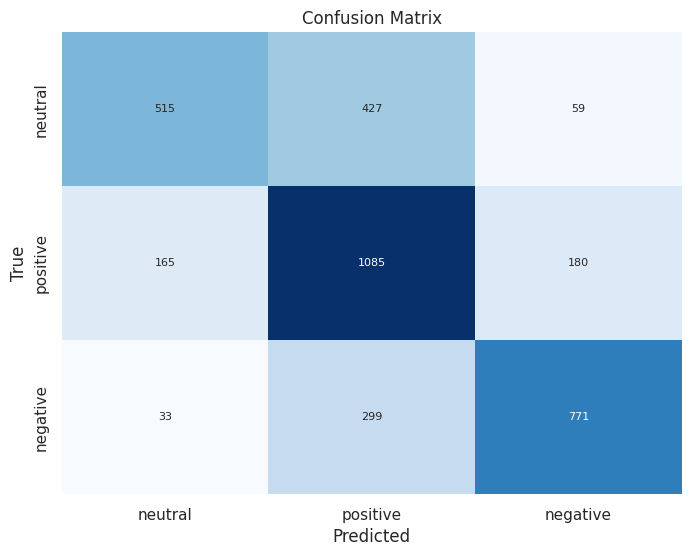

In [73]:
utils.plot_confusion_matrix(y_test, y_pred, classes=LABELS)

---
## Advanced Experiment: Fine-Tuning BERT
---
 Use `bert-base-uncased` pretrained model offered by Huggingface to train a classification model from train and report their performances on the validation dataset, in terms of accuracy, F1 score, precision and recall.
 

In [42]:
import torch.nn as nn
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [44]:
def print_exmples(text, tokenizer, n=3):
    tips = sns.load_dataset("tips")

    for i, sent in enumerate(text[:n+1]):
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        tokens = tokenizer.tokenize(sent)
        print(f"\n------------------------------- Sentence ({i}) has {len(tokens)} tokens ------------------------------- ")
        print('Original : ', sent)
        print('Tokenized: ', tokens)
        print('Token IDs: ', input_ids)

**Report the tokenizer's vocabulary size**

In [45]:
print(f" `bert-base-uncased` vocabulary size is {tokenizer.vocab_size} token (unique word).")

 `bert-base-uncased` vocabulary size is 30522 token (unique word).


**Present the tokenization results for the selected tokenizer on three examples**

In [46]:
train_texts = train_df['clean_text'].tolist()
print_exmples(train_texts, n=1, tokenizer = tokenizer)


------------------------------- Sentence (0) has 6 tokens ------------------------------- 
Original :  have responded , if were going
Tokenized:  ['have', 'responded', ',', 'if', 'were', 'going']
Token IDs:  [101, 2031, 5838, 1010, 2065, 2020, 2183, 102]

------------------------------- Sentence (1) has 13 tokens ------------------------------- 
Original :  Sooo SAD will miss you here in San Diego ! ! !
Tokenized:  ['soo', '##o', 'sad', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego', '!', '!', '!']
Token IDs:  [101, 17111, 2080, 6517, 2097, 3335, 2017, 2182, 1999, 2624, 5277, 999, 999, 999, 102]


In [47]:
val_texts = val_df['clean_text'].tolist()
print_exmples(val_texts, n=1, tokenizer = tokenizer)


------------------------------- Sentence (0) has 5 tokens ------------------------------- 
Original :  Last session of the day
Tokenized:  ['last', 'session', 'of', 'the', 'day']
Token IDs:  [101, 2197, 5219, 1997, 1996, 2154, 102]

------------------------------- Sentence (1) has 21 tokens ------------------------------- 
Original :  Shanghai is also really exciting precisely skyscrapers galore . Good tweeps in China SH BJ .
Tokenized:  ['shanghai', 'is', 'also', 'really', 'exciting', 'precisely', 'skyscraper', '##s', 'gal', '##ore', '.', 'good', 't', '##wee', '##ps', 'in', 'china', 'sh', 'b', '##j', '.']
Token IDs:  [101, 8344, 2003, 2036, 2428, 10990, 10785, 24581, 2015, 14891, 5686, 1012, 2204, 1056, 28394, 4523, 1999, 2859, 14021, 1038, 3501, 1012, 102]


In [48]:
# def format_time(elapsed):
#     '''
#     Takes a time in seconds and returns a string hh:mm:ss
#     '''
#     elapsed_rounded = int(round((elapsed)))
#     # Format as hh:mm:ss
#     return str(datetime.timedelta(seconds=elapsed_rounded))

### 1. Propressing Steps by BERT Tokenization

Tokenize all of the sentences and map the tokens to thier word IDs using `encode_plus`, For every sentence :

**(1) Tokenize the sentence.**

**(2) Prepend the `[CLS]` token to the start.**

**(3) Append the `[SEP]` token to the end.**

**(4) Map tokens to their IDs.**

**(5) Pad or truncate the sentence to `max_length`**

**(6) Create attention masks for `[PAD]` tokens.**

In [49]:
def Preprocessing_for_bert(data, MAX_LEN = 64, tokenizer=tokenizer):
    """
    Perform required preprocessing steps for pretrained BERT.
    Arg:
        data (list): List of texts to be processed.
    Return:
        input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
        attention_masks (torch.Tensor): Tensor of indices specifying which tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text= sent, 
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            padding = 'max_length',         # Pad sentence to max length
            truncation=True,
#             return_tensors='pt',            # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [50]:
MAX_LEN = 13

print('Tokenizing Training Data 😴😴😴')
train_inputs, train_masks = Preprocessing_for_bert(train_texts, MAX_LEN, tokenizer=tokenizer)
print('Tokenizing Validation Data 😴😴😴')
val_inputs, val_masks = Preprocessing_for_bert(val_texts, MAX_LEN, tokenizer=tokenizer)

Tokenizing Training Data 😴😴😴
Tokenizing Validation Data 😴😴😴


In [51]:
train_inputs

tensor([[  101,  2031,  5838,  1010,  2065,  2020,  2183,   102,     0,     0,
             0,     0,     0],
        [  101, 17111,  2080,  6517,  2097,  3335,  2017,  2182,  1999,  2624,
          5277,   999,   102],
        [  101,  2026,  5795,  2003, 18917,  2033,  1012,  1012,  1012,   102,
             0,     0,     0],
        [  101,  2054,  4357,   999,  2681,  2033,  2894,   102,     0,     0,
             0,     0,     0],
        [  101,  4124,  1997,  1010,  2339,  2481,  2027,  2404,  2068,  2006,
          1996,  7085,   102],
        [  101,  2070,  9467,  3238, 13354,  4726,  2005,  1996,  2190,  7181,
          7057,  2006,   102],
        [  101,  2572,  8521,  2015,  2005,  1996,  3336,  2024,  4569,  2043,
          2002,  2003,   102],
        [  101, 17111,  9541,  2152,   102,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  2119,  1997,  2017,   102,     0,     0,     0,     0,     0,
             0,     0,     0],
        [ 

### 2. Create DataLoader

In [52]:
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(val_df['label'].values)

In [53]:
BATCH_SIZE = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

### 3. Model Building
I will use `BertForSequenceClassification`. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier.

In [54]:
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        Args:
            bert: a BertModel object
            classifier: a torch.nn.Module classifier
            freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H1, H2, D_out = 768, 128, 64, 6

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        Args:
            input_ids (torch.Tensor): an input tensor with shape (batch_size, max_length)
            attention_mask (torch.Tensor): a tensor that hold attention mask information with shape (batch_size, max_length)
            logits (torch.Tensor): an output tensor with shape (batch_size, num_labels)
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### 4. Optimizer & Learning Rate Scheduler

In [55]:
def Initalize_classifier(LR, EPOCHS=4):
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=LR,    # Default learning rate is 5e-5
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * EPOCHS

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier,optimizer, scheduler

### 5. Training Loop
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)



### 6. Evalution

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [56]:
from sklearn.metrics import precision_recall_fscore_support
def Evaluation(model, dataloader, dataset = 'Validation'):

    model.eval()
    accuracy = []
    f1_score = []
    precision = []
    recall = []
    total_loss = 0
    
    for batch in dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        # Compute loss
        loss = LOSS_FUNC(logits, b_labels)
        total_loss += loss.item()

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        acc = (preds == b_labels).cpu().numpy().mean() * 100
        accuracy.append(acc)
        
        precision, recall, f1_score, _ = precision_recall_fscore_support(b_labels.cpu().numpy(), 
                                                                         preds.cpu().numpy(),
                                                                         zero_division=1, average='weighted')

    # Compute the average accuracy and loss over the validation set.
    avg_loss = total_loss / len(dataloader)
    avg_acc = np.mean(accuracy)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1_score = np.mean(f1_score)

    performance_stats = {
        f'{dataset}_Loss': avg_loss,
        f'{dataset}_Accuracy': avg_acc,
        f'{dataset}_Precsion': avg_precision,
        f'{dataset}_Recall': avg_recall,
        f'{dataset}_F1_score':avg_f1_score,
    }
    return performance_stats

In [ ]:

def train(model, train_dataloader, val_dataloader=None, evaluate = False, epochs=4):
    epochs_stats={
            'Epoch':[],
            'Training_Loss': [],
            'Training_Accuracy': [],
            'Training_Time': [],
    }
    for epoch_i in range(epochs):
        
        print("="*72)
        print(f"{f'Training Epoch {epoch_i+1} on Training data':^72}")
        print("="*72)
        print("-"*72)
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Accuracy(%)':^14} | {'Elapsed Time(sec)':^9}")
        print("-"*72)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        batch_acc = []
        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = LOSS_FUNC(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            # Calculate the accuracy rate 
            preds = torch.argmax(logits, dim=1).flatten()
            acc = (preds == b_labels).cpu().numpy().mean() * 100
            batch_acc.append(acc)
            # Perform a backward pass to calculate gradients
            loss.backward()
            
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 32 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {acc:^17.2f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
    
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_acc = np.array(batch_acc).mean() 
        time_elapsed = time.time() - t0_epoch

        epochs_stats['Epoch'].append(epoch_i + 1)
        epochs_stats['Training_Loss'].append(avg_train_loss)
        epochs_stats['Training_Accuracy'].append(avg_train_acc)
        epochs_stats['Training_Time'].append(time_elapsed)

        print("-"*72)
        print(f"{'Agg':^7} | {'-':^7} | {avg_train_loss:^12.6f} | {avg_train_acc:^17.2f} | {time_elapsed:^9.2f}")
        if evaluate:
            print("="*72)
            print(f"{f'Evaluating {epoch_i+1} on Validation data':^72}")
            epochs_stats.update(Evaluation(model, val_dataloader, dataset = 'Validation'))
            print("="*72)
            print(f"{'Epoch':^7}|{'Loss':^7}|{'Accuracy(%)':^13}|{'Precsion':^12}|{'Recall':^12}|{'F1-score':^12}")
            print("-"*72)
            print(f"{f'Avg {epoch_i+1}':^7}|{epochs_stats['Validation_Loss']:^7.2f}|{epochs_stats['Validation_Accuracy']:^13.2f}|{epochs_stats['Validation_Precsion']:^12.2f}|{epochs_stats['Validation_Recall']:^12.2f}|{epochs_stats['Validation_F1_score']:^12.2f}")
        print("\n")

    print("Training complete!")
    return epochs_stats

In [58]:
EPOCHS = 2
LR = 2e-5
LOSS_FUNC = nn.CrossEntropyLoss()

bert_classifier,optimizer, scheduler = Initalize_classifier(LR, EPOCHS)
performance_stats = train(bert_classifier, train_dataloader,val_dataloader, evaluate = True, epochs=EPOCHS)

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


                   Training Epoch 1 on Training data                    
------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  | Train Accuracy(%) | Elapsed Time(sec)
------------------------------------------------------------------------
   1    |    1    |   1.750888   |       33.33       |   61.57  
------------------------------------------------------------------------
  Agg   |    -    |   1.750888   |       36.98       |   61.67  
                    Evaluating 1 on Validation data                     
 Epoch | Loss  | Accuracy(%) |  Precsion  |   Recall   |  F1-score  
------------------------------------------------------------------------
 Avg 1 | 1.74  |    35.76    |    0.80    |    0.28    |    0.12    


                   Training Epoch 2 on Training data                    
------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  | Train Accuracy(%) | Elapsed Time(sec)


In [ ]:
def learning_curve(accuracy, loss, i, palette_color):
    """
    Plots the learning curve of a model's accuracy over batches.

    This function visualizes the model's accuracy progression during training.
    It creates a line plot showing the accuracy values for each batch within a specific epoch.

    Args:
        accuracy (list): A list of accuracy values for each batch in an epoch.
        i (int): The epoch number.

    Returns:
        None
    """
    plt.figure(figsize=(10,4))
    plt.plot(accuracy, '-',color=palette_color[0], label='Accuracy')
    plt.plot(loss, '-',color=palette_color[2], label='Loss')

    # Label the plot.
    plt.title(f"Model Accuracy and Loss over Epochs")
    plt.xlabel("Epoch")
    plt.legend()

    plt.show()

In [ ]:
performance_stats

{'Epoch': 1,
 'Training_Loss': 1.7508875727653503,
 'Training_Accuracy': 36.979166666666664,
 'Training_Time': 33.388596296310425,
 'Validation_Loss': 1.7438547611236572,
 'Validation_Accuracy': 35.763888888888886,
 'Validation_Precsion': 0.7993827160493827,
 'Validation_Recall': 0.2777777777777778,
 'Validation_F1_score': 0.12077294685990338,
 'Testing_Loss': 1.7438547611236572,
 'Testing_Accuracy': 35.763888888888886,
 'Testing_Precsion': 0.7993827160493827,
 'Testing_Recall': 0.2777777777777778,
 'Testing_F1_score': 0.12077294685990338}

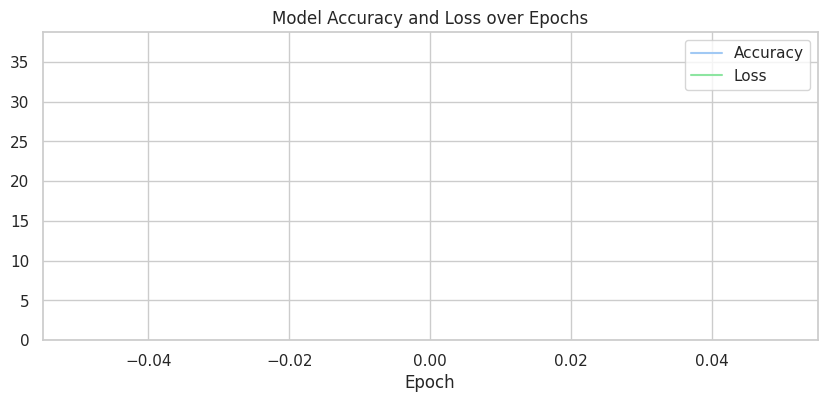

In [ ]:

learning_curve(performance_stats['Training_Accuracy'],
                     performance_stats['Training_Loss'], 
                     performance_stats['Epoch'], palette_color)

In [ ]:
performance_stats.update(Evaluation(bert_classifier, val_dataloader, dataset = 'Validation'))

In [ ]:
stats_df = pd.DataFrame(columns = ['Loss', 'Accuracy', 'Precsion', 'Recall', 'F1_score', 'Time'], index = ['Training', 'Validation'])

for k, v in performance_stats.items():
    for col in stats_df.columns:
        for idx in stats_df.index:
            if k.startswith(idx) and k.endswith(col):
                 stats_df.loc[idx, col]=v
stats_df = stats_df.replace({np.nan: '-'})
stats_df

/tmp/ipykernel_15566/1490886495.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stats_df = stats_df.replace({np.nan: '-'})


,Loss,Accuracy,Precsion,Recall,F1_score,Time
Training,1.7509,36.9792,-,-,-,33.3886
Validation,1.7439,35.7639,0.7994,0.2778,0.1208,-
Testing,1.7439,35.7639,0.7994,0.2778,0.1208,-
